In [1]:
from datetime import datetime as dt
import uuid 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
in_path = './../../../'
dataset = pd.read_csv(
    in_path+'splunk_data_180918_telenor_processed.txt',  
    encoding="ISO-8859-1", 
    dtype={
        "user_id": int, 
        "visit_id": int, 
        "sequence": int, 
        "start_time":object, 
        "event_duration":float,
        "url":str, 
        "action":str, 
        "country":str,
        "user_client":str,
        "user_client_family":str,
        "user_experience":str,
        "user_os":str,
        "apdex_user_experience":str,
        "bounce_rate":float,
        "session_duration":float
    }
)


In [3]:
t = dataset
t.columns = t.columns.str.replace('min_bedrift_event.','')
t = t[~t.action.isnull()]

# drop NaN actions or urls
t = t.dropna(axis='rows', how='any',subset=['url', 'action'])
#t = t.reset_index()

In [4]:
len(t.index)

3605250

In [5]:
 # define time variables
# define time variables
t['start_time'] = t['start_time'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d %H:%M:%S:%f"))
t['start_time'] = t['start_time'].apply(lambda x: x.replace(microsecond=0))

t['date'] = t['start_time'].dt.date
t['hour'] = t['start_time'].dt.hour
t['DOW'] = t['start_time'].dt.dayofweek

# create new session_id based on load = "new browser session"
# visit_id is not a good measure, since people remain logged in for 1 hour. This was previously 2 hours.
# in the App, people remain logged in for 11 months, so visit_ids could carry on for a long time
# Advice: I would define a session based on inactivity. Create new session after 30 minutes inactivity
t.sort_values(['visit_id', 'start_time'], inplace=True)

t['lag_ts'] = t.sort_values(['visit_id','start_time']).groupby('visit_id')['start_time'].shift(1)
#t['lag_ts'].fillna(t['start_time'],inplace=True) # for the first event in session
t['inactivity'] = (t['start_time'] - t['lag_ts']) / np.timedelta64(1, 'm')

In [6]:
cond_inactivity = t.inactivity > 30
cond_url_not_NaN = t.url is not np.nan
cond_lag_ts_NaN = t.lag_ts is np.nan
cond_login = ((t.url == 'https://www.telenor.no/bedrift/minbedrift/beta/#/') | (t.url == 'https://www.telenor.no/bedrift/minbedrift/beta/') | (t.url == 'https://www.telenor.no/bedrift/minbedrift/beta/mobile-app.html#/')) & ("_load_" in t.action)
cond = cond_url_not_NaN & ((cond_login & cond_lag_ts_NaN) | cond_inactivity)

t['tmp'] = cond.groupby(t.visit_id).cumsum().where(cond, 0).astype(int).replace(to_replace=0, method='ffill')

t['sequence'] = t.groupby(['tmp', 'visit_id']).cumcount() + 1
t['UUID'] = 1
t.loc[:, "UUID"] = t.groupby(['user', 'tmp', 'visit_id'])['UUID'].transform(lambda g: uuid.uuid4())

# drop all sessions with 1 event (since they are duplicates)
t['uuid_count'] = t.groupby('UUID').UUID.transform('count')
t = t[t.uuid_count > 1]

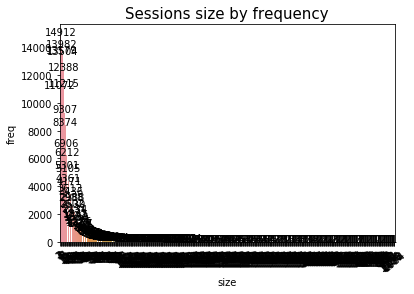

In [14]:
df = pd.DataFrame({'size':t.groupby('UUID').size()})
freq = pd.DataFrame({'freq':df.groupby('size').size()})
freq['size'] = freq.index
freq['inx'] = range(len(freq))
ax = sns.barplot(x="size", y="freq", data=freq)
ax.set_xticklabels(freq["size"], rotation=40)
for index, row in freq.iterrows():
    ax.text(row.inx, row.freq, row.freq, color='black', ha="center")
plt.title("Sessions size by frequency", fontsize=15)
plt.savefig('img/session_freq.png')

In [34]:
sns.set_style('white')

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [24]:
df = pd.DataFrame({'size':dataset.groupby('visit_id').size()})
freq = pd.DataFrame({'freq':df.groupby('size').size()})
freq.T.head(100)

size,1,2,3,4,5,6,7,8,9,10,...,944,973,981,1034,1196,1204,1404,1438,1692,1954
freq,21202,11056,14916,13956,13557,13510,12364,11235,9302,8386,...,1,1,1,1,1,1,1,1,1,1


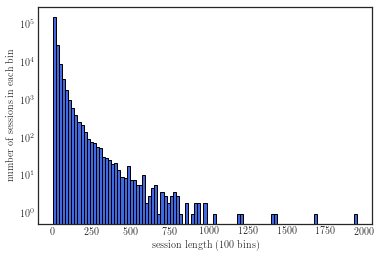

100

In [37]:
# 10 bins histogram

df = pd.DataFrame({'size':dataset.groupby('visit_id').size()})
bins = np.linspace(0,df.max(),100)
n, bins, pathces = plt.hist(x=df.values,bins=bins,log=True,color='royalblue',edgecolor='black')
#plt.xticks(bins)
plt.xlabel('session length (100 bins)')
plt.ylabel('number of sessions in each bin')
step = bins[1]/2
#for x,y in zip(bins,n):
#    plt.text(x+step, (y + 0.1 * y),'%.0f' % y, color='black', ha='center')
plt.savefig("img/session_freq.pdf", bbox_inches='tight')
plt.show()
len(bins)

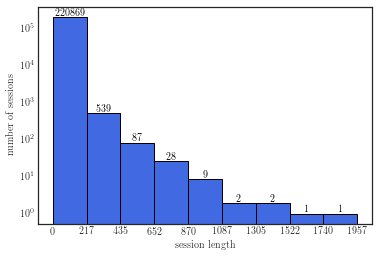

In [145]:
# 10 bins histogram

df = pd.DataFrame({'size':dataset.groupby('visit_id').size()})
bins = np.linspace(0,df.max(),10)
n, bins, pathces = plt.hist(x=df.values,bins=bins,log=True,color='royalblue',edgecolor='black')
plt.xticks(bins)
plt.xlabel('session length')
plt.ylabel('number of sessions')
step = bins[1]/2
for x,y in zip(bins,n):
    plt.text(x+step, (y + 0.1 * y),'%.0f' % y, color='black', ha='center')
plt.savefig("img/session_freq.pdf", bbox_inches='tight')
plt.show()


In [52]:
over_30 = t[(t['inactivity'] > 20)].shape[0]/t.dropna(subset=['inactivity']).shape[0]
print(over_30)
under_30 = t[(t['inactivity'] <= 20)].shape[0]/t.dropna(subset=['inactivity']).shape[0]
print(under_30)
print(over_30 + under_30)

0.0026376171190660262
0.9973623828809339
1.0


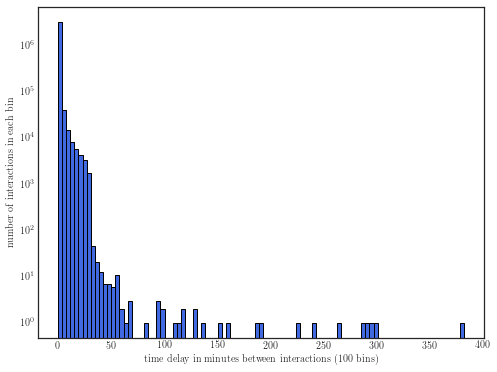

3383736


In [48]:
plt.figure(figsize=(8,6.1))

bins = np.linspace(0,t.inactivity.max(),100)
n, bins, pathces = plt.hist(x=t.inactivity.dropna(),bins=bins,log=True,color='royalblue',edgecolor='black')
#plt.xticks(bins)
plt.xlabel('time delay in minutes between interactions (100 bins)')
plt.ylabel('number of interactions in each bin')
'''
step = bins[1]/2
for x,y in zip(bins,n):
    ycord = 0.5
    if y != 0:
        ycord = y
    plt.text(x+step, (ycord + 0.1 * ycord), '%.0f' % y, color='black', ha='center')
'''
plt.savefig("img/time_delay.pdf", bbox_inches='tight')
plt.show()

print(len(t.inactivity.dropna()))

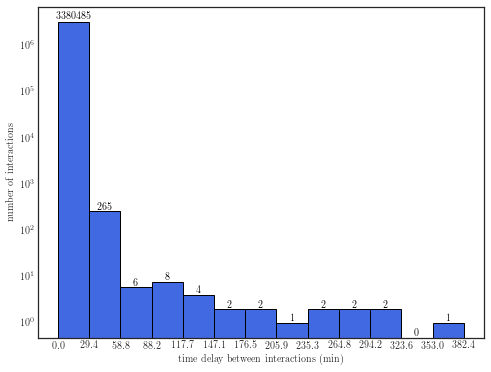

3380780


In [148]:
plt.figure(figsize=(8,6.1))

bins = np.linspace(0,t.inactivity.max(),14)
n, bins, pathces = plt.hist(x=t.inactivity.dropna(),bins=bins,log=True,color='royalblue',edgecolor='black')
plt.xticks(bins)
plt.xlabel('time delay between interactions (min)')
plt.ylabel('number of interactions')
step = bins[1]/2
for x,y in zip(bins,n):
    ycord = 0.5
    if y != 0:
        ycord = y
    plt.text(x+step, (ycord + 0.1 * ycord), '%.0f' % y, color='black', ha='center')
plt.savefig("img/time_delay.pdf", bbox_inches='tight')
plt.show()

print(len(t.inactivity.dropna()))

In [82]:
small_session = dataset.loc[dataset['visit_id'] == 30480842]
small_session

,visit_id,sequence,start_time,event_duration,url,action,country,user_client,user_client_family,user_experience,user_os,apdex_user_experience,bounce_rate,session_duration,site,duration,exec_time,failed,partition_date,user
3873179,30480842,1,2018-09-17 11:13:09:690,NaN,NaN,NaN,Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,691.00000,691.00000,NaN,2018-09-17,1380
3873180,30480842,2,2018-09-17 11:13:09:690,0.000,NaN,NaN,Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,691.00000,691.00000,NaN,2018-09-17,1380
3873181,30480842,3,2018-09-17 11:13:09:690,0.000,NaN,NaN,Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,691.00000,691.00000,NaN,2018-09-17,1380
3873182,30480842,4,2018-09-17 11:13:09:690,0.000,https://www.telenor.no/bedrift/minbedrift/beta/#/,_load_,Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,5230.19873,5999.19873,NaN,2018-09-17,1380
3873215,30480842,5,2018-09-17 11:13:29:938,20.248,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Nytt abonnement eller eierskifte""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,311.00000,311.00000,NaN,2018-09-17,1380
3873216,30480842,6,2018-09-17 11:13:31:841,1.903,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Opprett nytt abonnement fra grunnen av""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,192.00000,192.00000,NaN,2018-09-17,1380
3873219,30480842,7,2018-09-17 11:13:33:590,1.750,https://www.telenor.no/bedrift/minbedrift/beta/#/,"click on ""Abonnement for tale og data""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,823.00000,823.00000,NaN,2018-09-17,1380
3873221,30480842,8,2018-09-17 11:13:36:160,2.570,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Fortsett""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,2640.00000,7173.00000,NaN,2018-09-17,1380
3873254,30480842,9,2018-09-17 11:14:00:301,24.141,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Finn person""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,436.00000,436.00000,NaN,2018-09-17,1380
3873269,30480842,10,2018-09-17 11:14:09:732,9.431,https://www.telenor.no/bedrift/minbedrift/beta...,"click on ""Neste Lagre""",Norway - Sor-Trondelag - Trondheim,IE 11.0,IE,satisfied,Windows,satisfied,NaN,41.429,NaN,404.00000,404.00000,NaN,2018-09-17,1380


In [13]:
len(set(t.UUID))

200324

In [46]:

#t[t['UUID'] == 0000547e-8d48-4e81-aca7-59b496011ead]
t.groupby(['UUID'])['action_cleaned'].value_counts().max()

783

In [28]:
z =s.head(4)
z = z[['visit_id','start_time','url','action']]
pd.set_option('max_colwidth', 20)
z

,visit_id,start_time,url,action
3873182,30480842,2018-09-17 11:13:09,https://www.tele...,_load_
3873215,30480842,2018-09-17 11:13:29,https://www.tele...,"click on ""Nytt a..."
3873216,30480842,2018-09-17 11:13:31,https://www.tele...,"click on ""Oppret..."
3873219,30480842,2018-09-17 11:13:33,https://www.tele...,"click on ""Abonne..."


In [29]:
with open("my_table.tex", "w") as f:
    f.write(z.to_latex(index=False))

In [1]:
import pickle 

s = pickle.load( open( "./cleaned_dataset.p", "rb" ) )

/home/aksel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'UUID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


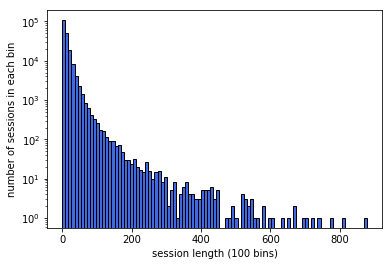

100

In [4]:
# 10 bins histogram

df = pd.DataFrame({'size':s.groupby('UUID').size()})
bins = np.linspace(0,df.max(),100)
n, bins, pathces = plt.hist(x=df.values,bins=bins,log=True,color='royalblue',edgecolor='black')
#plt.xticks(bins)
plt.xlabel('session length (100 bins)')
plt.ylabel('number of sessions in each bin')
step = bins[1]/2
#for x,y in zip(bins,n):
#    plt.text(x+step, (y + 0.1 * y),'%.0f' % y, color='black', ha='center')
plt.savefig("img/new_session_freq.pdf", bbox_inches='tight')
plt.show()
len(bins)